In [1]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import glob
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import tensorflow as tf                
from tqdm import tqdm
from sklearn import metrics



In [2]:
##Resize images to
SIZE = 256

In [3]:
train_images,train_labels=np.load('x_train.npy'),np.load('y_train.npy')

In [17]:
print(type(train_images))

<class 'numpy.ndarray'>


In [4]:
test_images,test_labels = np.load('x_test.npy'), np.load('y_test.npy')

In [ ]:
#Capture images and labels into arrays.
#Start by creating empty lists.
train_images = []
train_labels = [] 

In [ ]:
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("input/train/*"):
    head_tail = os.path.split(directory_path)
    label = head_tail[1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
        
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)      
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
    
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)      
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


Text(0.5, 1.0, 'Label')

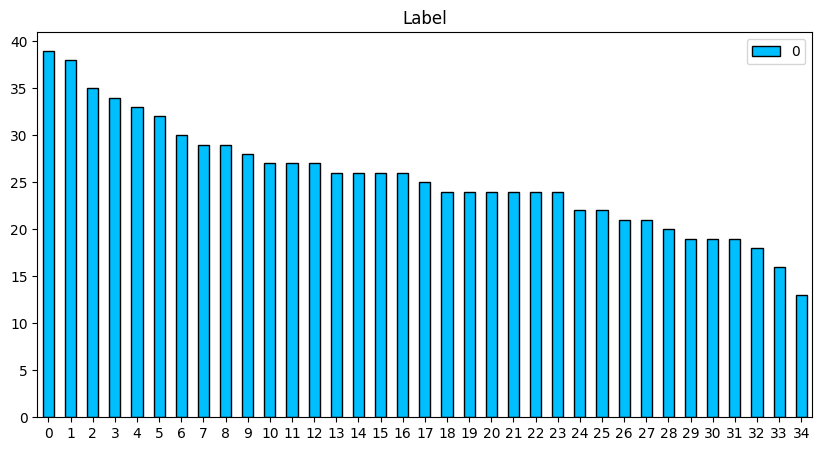

In [48]:
# Draw a graph with the number of target
train_labels_show.value_counts().to_frame().plot.bar(figsize=(10,5),color='deepskyblue',linewidth=1,edgecolor='black') 
plt.xticks(range(35), range(35))
plt.xticks(rotation=0)
plt.title('Label')


In [6]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(train_images , train_labels , train_size=0.8, test_size=0.2,random_state=42)

In [5]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [6]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
# np.save('x_test.npy',np.array(test_images))
# np.save('y_test.npy',np.array(test_labels))
# np.save('x_train.npy',np.array(train_images))
# np.save('y_train.npy',np.array(train_labels))

In [7]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-29 20:04:33.771218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-29 20:04:33.771593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_for_training = features #This is our X input to RF

 1/28 [>.............................] - ETA: 4s

2023-03-29 20:04:37.281381: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-29 20:04:37.341707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 4s 153ms/step


In [11]:
print(feature_extractor)

[[[[0.         0.         0.         ... 0.         1.3009923
    0.        ]
   [0.         0.         0.         ... 0.         0.6301477
    0.        ]
   [0.         0.         0.         ... 0.         0.74698687
    0.        ]
   ...
   [0.06576407 0.         0.         ... 0.         0.7912009
    0.        ]
   [0.50013834 0.         0.         ... 0.         0.
    0.        ]
   [0.7236768  0.         0.         ... 0.         0.4849839
    0.        ]]

  [[0.         0.         0.         ... 0.         1.0731466
    0.        ]
   [0.         0.         0.01960981 ... 0.         0.82424325
    0.        ]
   [0.         0.         0.21585566 ... 0.         0.72227144
    0.        ]
   ...
   [0.         0.         0.8484225  ... 0.         1.7903132
    0.        ]
   [0.34605056 0.         0.16635734 ... 0.         0.5581105
    0.        ]
   [0.5464785  0.         0.         ... 0.         0.6169929
    0.        ]]

  [[0.         0.         0.         ... 0.       

In [18]:
np.save('features.npy',np.array(features))

In [13]:
x2 = x_train.reshape(feature_extractor.shape[0], -1)

(891, 196608)

In [20]:
print(X_for_training[0][1]-2)

-2.0


In [39]:
X_for_training[0][]

array([0.       , 0.       , 0.       , ..., 0.       , 0.9983141,
       0.       ], dtype=float32)

In [28]:
np.seterr(divide='ignore', invalid='ignore')
x_min, x_max = np.min(X_for_training,axis=0), np.max(X_for_training,axis=0)
X = (X_for_training - x_min) / (x_max - x_min)

In [34]:
X = pd.DataFrame(X)
X = X.fillna(0)

In [37]:
X = X.values

Computing t-SNE embedding


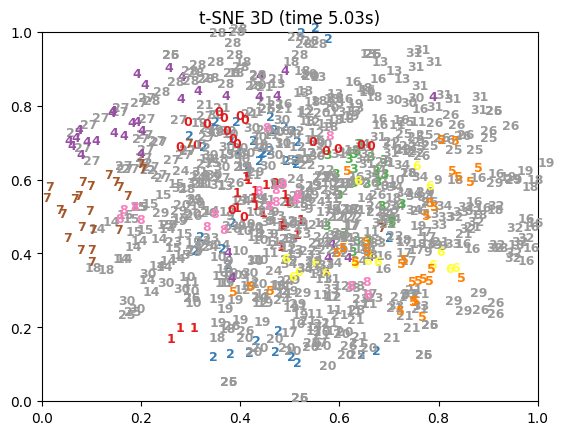

In [38]:
from sklearn.manifold import TSNE
import seaborn as sns
from time import time
import copy

print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_o = copy.deepcopy(X_for_training)
X_tsne = tsne.fit_transform(X_for_training)


def plot_embedding_3d(X, title=None):
  x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
  X = (X - x_min) / (x_max - x_min)
  X = pd.DataFrame(X)
  X = X.fillna(0)
  X = X.values
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  for i in range(X.shape[0]):
    ax.text(X[i, 0], X[i, 1], str(y_train[i]), color=plt.cm.Set1(y_train[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
      plt.title(title)

plot_embedding_3d(X_tsne,"t-SNE 3D (time %.2fs)" %(time() - t0))

Computing t-SNE embedding


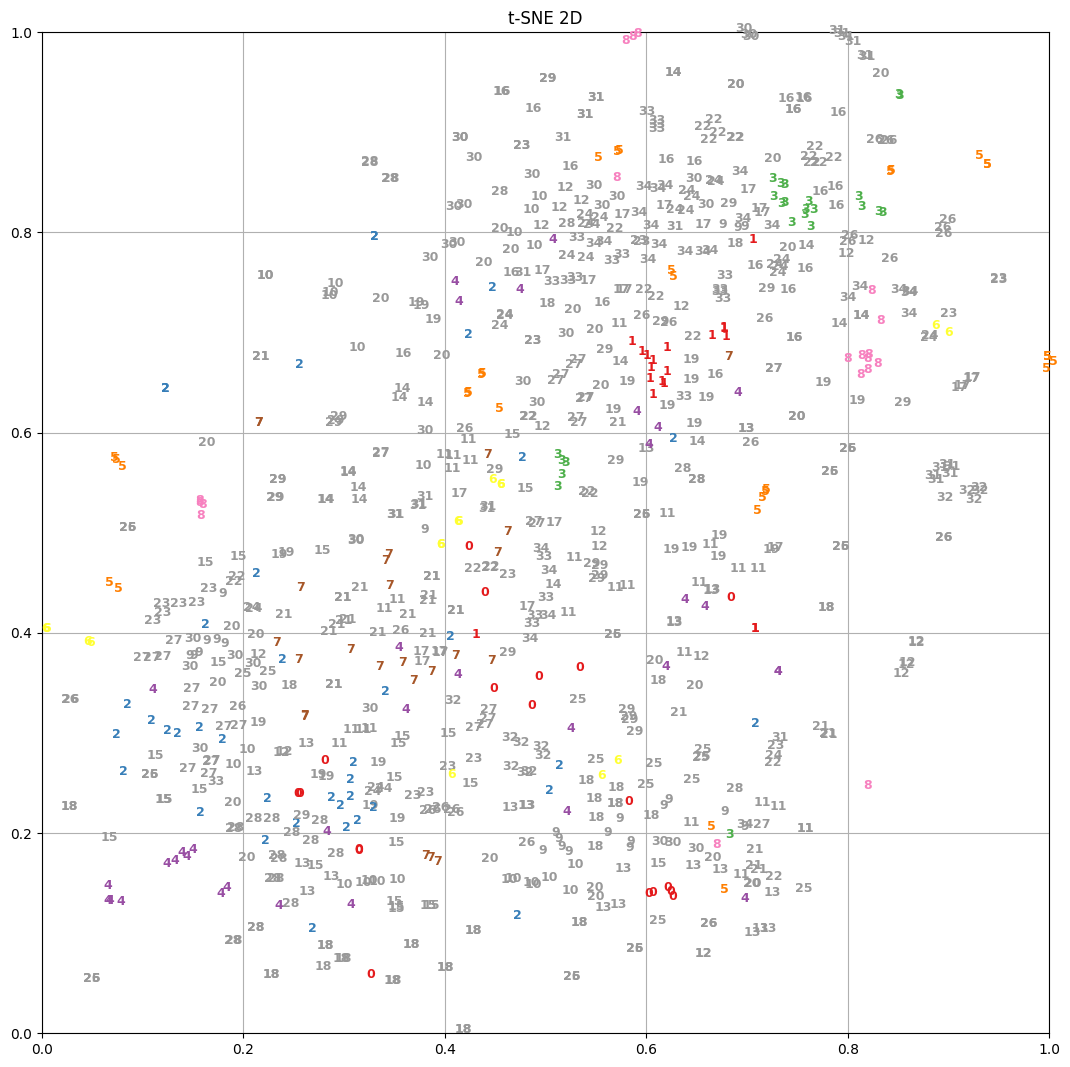

In [17]:
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X_o)

def plot_embedding_2d(x2, title=None):
    #x, y to [0,1]
  x_min, x_max = np.min(x2,axis=0), np.max(x2,axis=0)
  X = (x2 - x_min) / (x_max - x_min)

  fig = plt.figure(figsize=(13, 13))
  ax = fig.add_subplot(1, 1, 1)
  plt.grid()
  for i in range(X.shape[0]):
    ax.text(X[i, 0], X[i, 1], str(y_train[i]), color=plt.cm.Set1(y_train[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
      plt.title(title)

      
plot_embedding_2d(X_tsne,"t-SNE 2D")

In [40]:
X_tsne = tsne.fit_transform(X_for_training)

In [42]:
X_tsne.shape

(891, 2)

In [12]:
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X_for_training)

def plot_embedding_2d(X_for_training, title=None):
    #x, y to [0,1]
  x_min, x_max = np.min(X_for_training,axis=0), np.max(X_for_training,axis=0)
  X_for_training = (X_for_training - x_min) / (x_max - x_min)

  fig = plt.figure(figsize=(4, 4))
  ax = fig.add_subplot(1, 1, 1)
  plt.grid()
  for i in range(X.shape[0]):
    ax.text(X[i, 0], X[i, 1], str(y_train[i]), color=plt.cm.Set1(y_train[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
      plt.title(title)

      
plot_embedding_2d(X_tsne,"t-SNE 2D")

Computing t-SNE embedding


NameError: name 'TSNE' is not defined

In [36]:
X_o

array([[0.18431373, 0.21568627, 0.21960784, ..., 0.24705882, 0.22352941,
        0.17647059],
       [0.75686275, 0.92156863, 0.98431373, ..., 0.42352941, 0.37647059,
        0.32156863],
       [0.82352941, 0.93333333, 0.98039216, ..., 0.13333333, 0.15294118,
        0.1372549 ],
       ...,
       [0.36078431, 0.28627451, 0.22745098, ..., 0.39607843, 0.27058824,
        0.21176471],
       [0.50980392, 0.40392157, 0.3372549 , ..., 0.62352941, 0.42745098,
        0.34117647],
       [0.22745098, 0.09411765, 0.09803922, ..., 0.50196078, 0.38431373,
        0.28235294]])

# LR


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [17]:
logreg_clf_1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty ='l1', C= 0.1)


logreg_clf_1.fit(X_for_training, y_train)
feature_extractor_2=VGG_model.predict(x_test)
X_for_test =  feature_extractor_2.reshape(feature_extractor_2.shape[0], -1)

y_pred_lr_1 = logreg_clf_1.predict(X_for_test)

# # model_lassoreg_cv_rocaucscore = roc_auc_score(y_test, y_pred_lr_1)
# model_lassoreg_cv_cvscores = cross_val_score(logreg_clf_1, X_for_training, y_train, scoring='roc_auc')
# print('Roc Auc score: %0.4f, Cross validation score: %0.4f (+/- %0.4f)' %(model_lassoreg_cv_rocaucscore, model_lassoreg_cv_cvscores.mean(), 2 * model_lassoreg_cv_cvscores.std()))

#Cross Validation

accuracy_lr = accuracy_score(y_test,  y_pred_lr_1)
print('prediction accuracyy',accuracy_lr*100,'%')
print('model score' , logreg_clf_1.score(X_for_training, y_train)*100 ,'%')

6/6 [==============================] - 1s 158ms/step
prediction accuracyy 25.69832402234637 %
model score 76.65544332210999 %


# XGBOOST

In [112]:
import xgboost as xgb
#XGBOOST
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_for_training, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

6/6 [==============================] - 1s 243ms/step


In [113]:
#Now predict using the trained xgb model. 
prediction = model_xgb.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))
print('Train score = ' , model_xgb.score(X_for_training, y_train))

Accuracy =  0.659217877094972
Train score =  0.9887640449438202


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_state = 42
RFC_model = RandomForestClassifier(random_state = 42, criterion= 'gini',n_estimators = 200)

param_grid_RFC = {'random_state' : range(30,60,2)
                  #'n_estimators': [50,20,30,40],
                  # 'max_depth' : range(100,120,2), 
                  # 'min_samples_leaf' : range(50,201,20),
                #   'class_weight' : ['balanced', 'balanced_subsample'],
                #   'criterion' :['gini', 'entropy']
                }

grid_rf = GridSearchCV(estimator = RFC_model, param_grid = param_grid_RFC , scoring = 'roc_auc', verbose = 1)
grid_rf.fit(X_for_training, y_train)
print("Best Score:" + str(grid_rf.best_score_))
print("Best Parameters: " + str(grid_rf.best_params_))

In [13]:
#RANDOM FOREST
#Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state = 42, criterion= 'gini',n_estimators = 400, class_weight =  'balanced')
model_rf.fit(X_for_training, y_train)

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained xgb model. 
prediction_rf = model_rf.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_rf = le.inverse_transform(prediction_rf)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_rf))
print('Train score' , model_rf.score(X_for_training, y_train))


6/6 [==============================] - 1s 198ms/step
Accuracy =  0.994413407821229
Train score 0.9887766554433222


In [14]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

6/6 [==============================] - 1s 157ms/step


In [73]:
#RANDOM FOREST
#Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state = 42, criterion= 'gini',n_estimators = 400, class_weight =  'balanced')
model_rf.fit(X_19for_training, y_train)

#Send test data through same feature extractor process
X_test_feature = VGG_model_19.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained xgb model. 
prediction_rf = model_rf.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_rf = le.inverse_transform(prediction_rf)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_rf))
print('Train score' , model_rf.score(X_19for_training, y_train))

6/6 [==============================] - 2s 325ms/step
Accuracy =  0.8212290502793296
Train score 0.9887640449438202


In [ ]:
from sklearn.feature_selection import SelectFromModel
estimator = model_rf
selector = SelectFromModel(estimator=estimator,prefit=True)
x_new = selector.transform(X_for_training)
test_new  = selector.transform(X_test_features)

model_rf.fit(x_new, y_train)
prediction_rf = model_rf.predict(test_new)
#Inverse le transform to get original label back. 
prediction_rf = le.inverse_transform(prediction_rf)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_rf))
print('Train score' , model_rf.score(x_new, y_train))

# KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier
kn_model = KNeighborsClassifier(algorithm = 'auto',leaf_size=1 , n_neighbors= 19, p=3,weights='uniform')
kn_model.fit(X_for_training, y_train)

prediction_knn = kn_model.predict(X_test_features)
prediction_knn = le.inverse_transform(prediction_knn)

print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_knn))
print('Train score' , kn_model.score(X_for_training, y_train))

Accuracy =  0.4134078212290503
Train score 0.4845505617977528


# SVM

In [ ]:
#SVM
from sklearn.svm import SVC
svc = SVC(probability=True, gamma='scale')
parameter_grid = {'C': [0.01,0.1,1,10, 100, 1000],
                  'kernel': ['linear', 'rbf'],
                  'degree': [2]
                 }
grid_svc = GridSearchCV(svc, param_grid=parameter_grid, cv=2, scoring='roc_auc', n_jobs=-1)
grid_svc.fit(X_for_training, y_train)
print('Best parameters: {}'.format(grid_svc.best_params_))

In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Best parameters: {'C': 0.01, 'degree': 2, 'kernel': 'linear'}
model_svc = SVC()
model_svc.fit(X_for_training, y_train)

#Now predict using the trained xgb model. 
prediction_svc = model_svc.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_svc = le.inverse_transform(prediction_svc)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_svc))
print('Train score' , model_svc.score(x_train, y_train))

# Adaboost


In [11]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators = 100, learning_rate = 0.001)
abc.fit(X_for_training,y_train)

AdaBoostClassifier(learning_rate=0.001, n_estimators=100)

In [82]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained xgb model. 
prediction_abc = abc.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_abc = le.inverse_transform(prediction_abc)



from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_abc))
print('Train score' , abc.score(X_for_training, y_train))

6/6 [==============================] - 1s 165ms/step
Accuracy =  0.12290502793296089
Train score 0.23876404494382023


# ExtraTree

In [53]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators = 1000, random_state=66, n_jobs = -1,bootstrap = True)

etc.fit(X_for_training,y_train)


ExtraTreesClassifier(bootstrap=True, n_estimators=1000, n_jobs=-1,
                     random_state=66)

In [54]:
prediction_etc = etc.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_etc = le.inverse_transform(prediction_etc)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_etc))
print('Train score' , etc.score(X_for_training, y_train))

Accuracy =  0.8324022346368715
Train score 0.9887640449438202


# GBDT

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
gbdt_model = GradientBoostingRegressor(
    learning_rate=0.02,
    n_estimators=300,
    subsample=0.8,
    max_features=0.8,
    max_depth=3,
    verbose=2
)

gbdt_model.fit(X_for_training, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1          99.0239           0.6641            4.40m
         2          96.4416           0.7218            4.25m
         3          95.3627           0.8150            4.21m
         4          94.5177           0.2453            4.18m
         5          95.5741           0.5931            4.14m
         6          93.7792           0.7651            4.13m
         7          90.6770           0.7026            4.11m
         8          89.7402           0.4035            4.09m
         9          90.6183           0.6728            4.08m
        10          85.0136           0.5074            4.08m
        11          88.0888           0.2363            4.06m
        12          84.5295           0.3373            4.04m
        13          84.0699           0.6488            4.02m
        14          84.0440           0.4302            4.00m
        15          84.1271           0.2439            3.99m
       

GradientBoostingRegressor(learning_rate=0.02, max_features=0.8,
                          n_estimators=300, subsample=0.8, verbose=2)

In [110]:
# prediction_gbdt = gbdt_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_gbdt = le.inverse_transform(prediction_gbdt2)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_gbdt))
print('Train score' , gbdt_model.score(X_for_training, y_train))

Accuracy =  0.03910614525139665
Train score 0.9148331757742725


# CNN


In [ ]:
X_for_training_cnn  = X_for_training.reshape(-1,256,256,1)
x_test_cnn = x_test.reshape(-1,256,256,1)

In [ ]:
##Bulid CNN model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Compile the model
model_cnn.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 256

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:

predictions_cnn = model_cnn.predict(x_test)     # Vector of probabilities
prediction_cnn = np.argmax(predictions_cnn, axis = 1) # We take the highest probability
prediction_cnn = le.inverse_transform(prediction_cnn)

print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_cnn))


In [ ]:
# # print(prediction)
# Y_pred_classes = np.argmax(prediction,axis = 0) 
# print(Y_pred_classes)

Accuracy =  0.8435754189944135


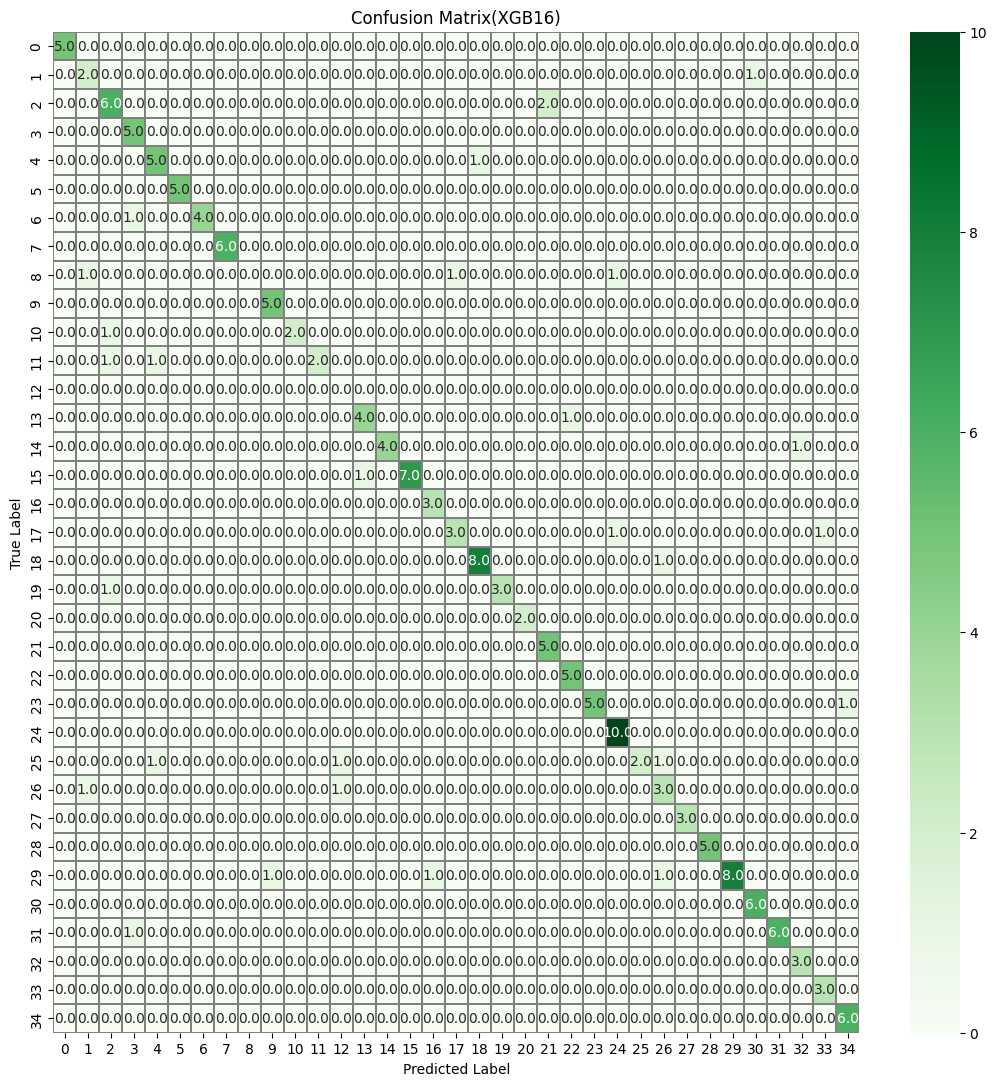

In [79]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_rf))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

# Y_pred_classes = np.argmax(prediction,axis = 0) 
# Y_true = np.argmax(y_test,axis = 0) 


cm = confusion_matrix(test_labels, prediction_rf)
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(13, 13))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

# print(cm)


sns.heatmap(cm, annot=True,linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix(XGB16)")
plt.show()

In [ ]:
# print(X_test_features)
# X_test_features.shape
print(X_for_training)
print(X_for_training.shape)
print(X_test_feature.shape)

[[[0.42745098 0.37254902 0.32156863]
  [0.45490196 0.4        0.34901961]
  [0.41960784 0.36470588 0.32156863]
  ...
  [0.78431373 0.7372549  0.68235294]
  [0.77647059 0.72941176 0.6745098 ]
  [0.75686275 0.70980392 0.65490196]]

 [[0.46666667 0.40392157 0.35294118]
  [0.44705882 0.39215686 0.34117647]
  [0.47058824 0.41568627 0.36470588]
  ...
  [0.74901961 0.70196078 0.64705882]
  [0.78431373 0.7372549  0.68235294]
  [0.78039216 0.73333333 0.67843137]]

 [[0.45098039 0.39607843 0.34509804]
  [0.45882353 0.40392157 0.35294118]
  [0.4745098  0.41960784 0.36862745]
  ...
  [0.76078431 0.71372549 0.65882353]
  [0.77254902 0.7254902  0.67058824]
  [0.77647059 0.72941176 0.6745098 ]]

 ...

 [[0.39215686 0.36470588 0.33333333]
  [0.4        0.37254902 0.34117647]
  [0.43137255 0.40392157 0.37254902]
  ...
  [0.54509804 0.44313725 0.43921569]
  [0.52941176 0.44705882 0.43529412]
  [0.57647059 0.49411765 0.49019608]]

 [[0.47843137 0.45098039 0.41960784]
  [0.40784314 0.38039216 0.34901961]


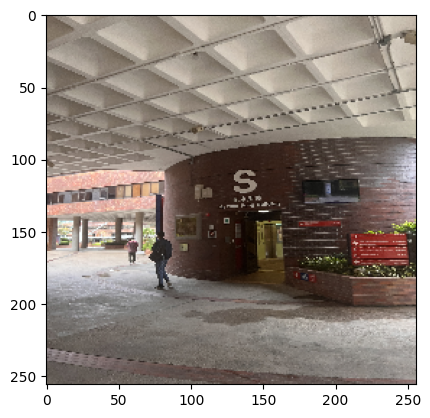

In [61]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print(img)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model_rf.predict(input_img_features)[0] 
print(prediction)
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])


(4032, 3024, 3)
(256, 256)
(256, 256, 3)
1/1 [==============================] - 0s 11ms/step
The prediction for this image is:  Chan Sui Wai Building (CoreE:Wing EF)


"'Chan Sui Wai Building (CoreE:Wing EF)'"

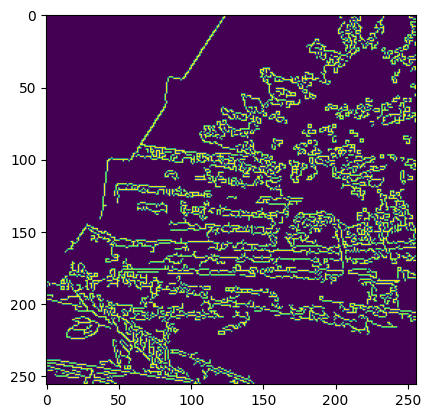

In [64]:

img_path = 'IMG_9409.JPG'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
print(gray.shape)  
   
img = cv2.resize(img, (SIZE, SIZE))
# OpenCV represents images in BGR order; however PIL represents
# images in RGB order, so we need to swap the channels
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
edged = cv2.Canny(gray, 500, 100)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# convert the images to PIL format...
plt.imshow(edged)
img = img / 255.0

input_img = np.expand_dims(img, axis=0)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model_rf.predict(input_img_features)[0]

prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction[0])
repr(prediction[0])





In [ ]:
inf = [
    [[0],['7-Eleven'],['Podium level, Shaw Amenities Building (Core VA)'],['You can buy drinks, snacks and other items here']],
                [[1], ['Anita Chan Lai Ling Building (Core P)'], ['NA'], ['NA']],
                [[2], ['Block X Sports Centre (Block X)'], ['NA'], ['NA']],
                [[3], ['CMA Building (Core C:Wing CD)'], ['NA'], ['NA']],
                [[4], ['Chan Sui Kau and Chan Lam Moon Chun Square'], ['NA'], ['NA']],
                [[5], ['Chan Sui Wai Building (CoreE:Wing EF)'], ['NA'], ['NA']],
                [[6], ['Chan Tai Ho Building (Core F:Wing FJ)'], ['NA'], ['NA']],
                [[7],['Cheung Che Man and Kwok Yuen Ho Bamboo Court(H-cafe)'],['NA'],['NA']],
                [[8], ['Choi Kai Yau Building (Core R:Wing QR)'], ['NA'], ['NA']],
                [[9], ['Chow Yei Ching Building (Core Q:Wing QT)'], ['NA'], ['NA']],
                [[10], ['Chung Sze Yuen Building (Core A:Wing AG)'], ['NA'], ['NA']],
                [[11], ['Communal Building (Core S)'], ['NA'], ['NA']],
                [[12], ['GH Podium Annexe (Core G:Wing GH)'], ['NA'], ['NA']],
                [[13], ['Global Student Hub'], ['NA'], ['NA']],
                [[14], ['Ho lu Kwong Building:Industrial Centre (Block W) '], ['NA'], ['NA']],
                [[15], ['Jockey Club Auditorium'], ['NA'], ['NA']],
                [[16], ['Jockey Club Innovation Tower (Block V)'], ['NA'], ['NA']],
                [[17], ['Kinmay W. Tang Building (Core F:Wing FG)'], ['NA'], ['NA']],
                [[18], ['Lawn (Lawn Cafe)'], ['NA'], ['NA']],
                [[19], ['Lee Shau Kee Building (Block Y)'], ['NA'], ['NA']],
                [[20], ['Li Ka Shing Tower (Block M)'], ['NA'], ['The place where AF, LMS, MM and FB in']],
                [[21], ['Library Cafe'], ['NA'], ['NA']],
                [[22], ['Lui Che Woo Building (Core D:Wing DE)'], ['NA'], ['NA']],
                [[23], ['Mong Man Wai Building (Wing PQ)'], ['NA'], ['It is now the Department of Computing (COMP)']],
                [[24],['Ng Wing Hong Building (Core S:Wing ST)'],['蒙民伟楼'],['NA']],
                [[25], ['Open Gate'], ['Redesigned as the main campus gate to celebrate the 85th anniversary of the university'],
                ['The main campus entrance is a clever blend of classic colonnade design and iconic red brick architecture']],
                [[26],['Pao Yue-Kong Library (Block L)'],['NA'],['NA']],
                [[27], ['Realink Building (Core U)'], ['NA'], ['NA']],
                [[28], ['SUBWAY'], ['NA'], ['NA']],
                [[29], ['Shaw Amenities Building (Block VA)'], ['NA'], ['NA']],
                [[30], ['Shirley Chan Building (Core R)'], ['NA'], ['NA']],
                [[31], ['Stanley Ho Building (Core J:Wing HJ)'], ['NA'], ['NA']],
                [[32],['Stephen Cheong Kam Chen Memorial Plaza:Flag raising platform'],['NA'],['NA']],
                [[33], ['Tang Ping Yuan Building (Core F:Wing CF)'], ['NA'], ['NA']],
                [[34], ['Yip Kit Chuen Building (Core T:Wing TU)'], ['NA'], ['NA']],
                ]

In [ ]:
torch.save(model_rf,'model.rf.pt')

In [ ]:

model_test = torch.load('model.rf.pt')
#Now predict using the trained xgb model. 
prediction_rf = model_test.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_rf = le.inverse_transform(prediction_rf)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_rf))
print('Train score' , model_test.score(X_for_training, y_train))

In [ ]:
(inf[0][1][0])

In [ ]:
le.inverse_transform([34])[0]

In [ ]:
for i in range(35):
    a = le.inverse_transform([i])[0]
    inf[i][1][0] = a



In [ ]:
inf = [
    [[0],['7-Eleven'],['Podium level, Shaw Amenities Building (Core VA)'],['You can buy drinks, snacks and other items here']],
                [[1], ['Anita Chan Lai Ling Building (Core P)'], ['NA'], ['NA']],
                [[2], ['Block X Sports Centre (Block X)'], ['NA'], ['NA']],
                [[3], ['CMA Building (Core C:Wing CD)'], ['NA'], ['NA']],
                [[4], ['Chan Sui Kau and Chan Lam Moon Chun Square'], ['NA'], ['NA']],
                [[5], ['Chan Sui Wai Building (CoreE:Wing EF)'], ['NA'], ['NA']],
                [[6], ['Chan Tai Ho Building (Core F:Wing FJ)'], ['NA'], ['NA']],
                [[7],
                ['Cheung Che Man and Kwok Yuen Ho Bamboo Court(H-cafe)'],
                ['NA'],
                ['NA']],
                [[8], ['Choi Kai Yau Building (Core R:Wing QR)'], ['NA'], ['NA']],
                [[9], ['Chow Yei Ching Building (Core Q:Wing QT)'], ['NA'], ['NA']],
                [[10], ['Chung Sze Yuen Building (Core A:Wing AG)'], ['NA'], ['NA']],
                [[11], ['Communal Building (Core S)'], ['NA'], ['NA']],
                [[12], ['GH Podium Annexe (Core G:Wing GH)'], ['NA'], ['NA']],
                [[13], ['Global Student Hub'], ['NA'], ['NA']],
                [[14], ['Ho lu Kwong Building:Industrial Centre (Block W) '], ['NA'], ['NA']],
                [[15], ['Jockey Club Auditorium'], ['NA'], ['NA']],
                [[16], ['Jockey Club Innovation Tower (Block V)'], ['NA'], ['NA']],
                [[17], ['Kinmay W. Tang Building (Core F:Wing FG)'], ['NA'], ['NA']],
                [[18], ['Lawn (Lawn Cafe)'], ['NA'], ['NA']],
                [[19], ['Lee Shau Kee Building (Block Y)'], ['NA'], ['NA']],
                [[20], ['Li Ka Shing Tower (Block M)'], ['NA'], ['NA']],
                [[21], ['Library Cafe'], ['NA'], ['The place where AF, LMS, MM and FB in']],
                [[22], ['Lui Che Woo Building (Core D:Wing DE)'], ['NA'], ['NA']],
                [[23], ['Mong Man Wai Building (Wing PQ)'], ['NA'], ['NA']],
                [[24],
                ['Ng Wing Hong Building (Core S:Wing ST)'],
                ['蒙民伟楼'],
                ['It is now the Department of Computing (COMP)']],
                [[25], ['Open Gate'], ['NA'], ['NA']],
                [[26],['Pao Yue-Kong Library (Block L)'],['Redesigned as the main campus gate to celebrate the 85th anniversary of the university.'],
                ['The main campus entrance is a clever blend of classic colonnade design and iconic red brick architecture']],
                [[27], ['Realink Building (Core U)'], ['NA'], ['NA']],
                [[28], ['SUBWAY'], ['NA'], ['NA']],
                [[29], ['Shaw Amenities Building (Block VA)'], ['NA'], ['NA']],
                [[30], ['Shirley Chan Building (Core R)'], ['NA'], ['NA']],
                [[31], ['Stanley Ho Building (Core J:Wing HJ)'], ['NA'], ['NA']],
                [[32],['Stephen Cheong Kam Chen Memorial Plaza:Flag raising platform'],['NA'],['NA']],
                [[33], ['Tang Ping Yuan Building (Core F:Wing CF)'], ['NA'], ['NA']],
                [[34], ['Yip Kit Chuen Building (Core T:Wing TU)'], ['NA'], ['NA']],
                [[35], ['Yip Kit Chuen Building (Core T/Wing TU)'], ['NA'], ['NA']]
                ]

In [130]:
print(X_for_training)

[[0.15745911 0.         0.         ... 0.         1.378735   0.        ]
 [0.08952393 0.         0.         ... 0.         1.6183822  0.        ]
 [0.         0.         0.         ... 0.         0.60799015 0.        ]
 ...
 [0.6197273  0.         0.5758112  ... 0.         0.51780057 0.        ]
 [1.2892042  0.         0.         ... 0.         1.1699622  0.        ]
 [0.         0.         0.         ... 0.10983031 0.68771505 0.        ]]
